Let's start by installing hugging face's transformers library.

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 11.1 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#importing necessary libraries
import re
import string
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

# Data Loading

Let's start processing the data. The dataset is devided into test and train files. Loading data from tsv file.


In [ ]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
print("Train dataset shape", train_df.shape)
print("Test dataset shape", test_df.shape)

Train dataset shape (5758, 2)
Test dataset shape (1000, 2)


# Data Visualization

Let's understand the train data set by the help of visulazation techniques.

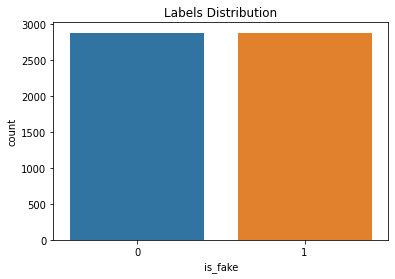

In [ ]:
sns.countplot(x=train_df.is_fake)
plt.title("Labels Distribution")
plt.show()

The Data Set is balaced with same number of observations for both the classes.

In [ ]:
#number of words in each review text
train_df['no_of_words'] = train_df['title'].apply(lambda x: len(x.split()))

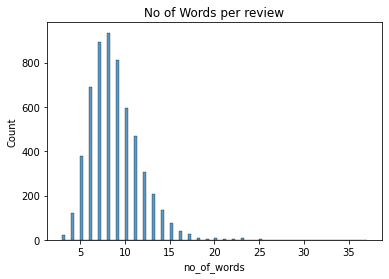

In [ ]:
sns.histplot(train_df['no_of_words'])
plt.title("No of Words per review")
plt.show()

In [ ]:
train_df['no_of_words'].describe()

count    5758.000000
mean        8.723689
std         2.810851
min         3.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        37.000000
Name: no_of_words, dtype: float64

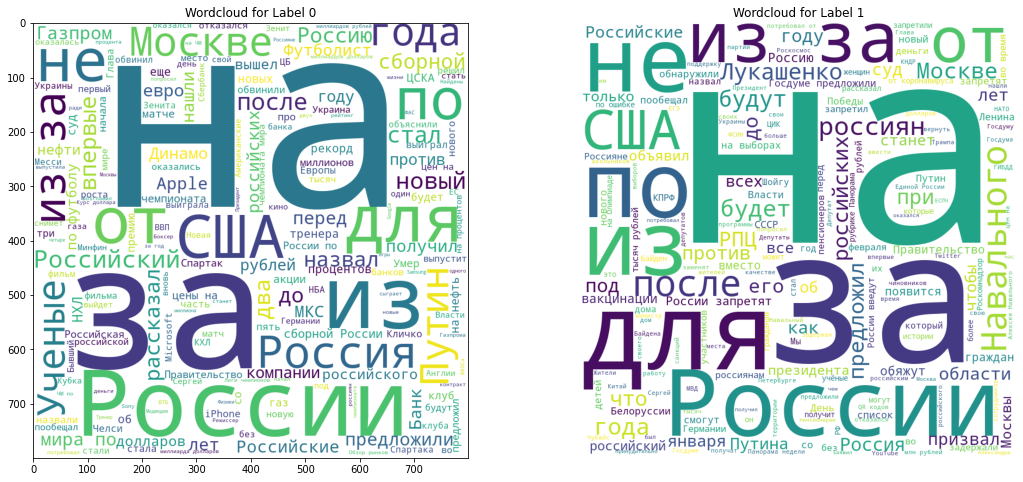

In [ ]:
plt.figure(figsize=(18, 8), facecolor=None)

for i in range(0,2):
  reviewes = " ".join(train_df[train_df.is_fake == i]['title'])
  wordcloud = WordCloud(width=800, height=800,
                  background_color='white',
                  min_font_size=5).generate(reviewes)

  plt.subplot(1, 2, i+1)
  plt.imshow(wordcloud)
  plt.title("Wordcloud for Label "+str(i))

plt.axis("off")
plt.show()

# Data Preperation

Let's Split the train data set into validationa and train. Validation data set will be used for evaluation after each epoch.

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=.15)

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(4894, 3)
(864, 3)
(1000, 2)


Let's create a Dataset object, which will be used iterate through all the values in training.

In [ ]:
class Text_Dataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    # tokenizing and converting them to index
    encodings = tokenizer(self.data.iloc[idx][0], truncation=True, padding="max_length", max_length=128)
    encodings['labels'] = self.data.iloc[idx][1]    
    return encodings

  def __len__(self):
    return self.data.shape[0]

In [ ]:
#creating datset classes for train, validationa and test data
train_dataset = Text_Dataset(train_df)
val_dataset = Text_Dataset(val_df)
test_dataset = Text_Dataset(test_df)

# Model Selection


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")

model = AutoModelForSequenceClassification.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru", num_labels=2)

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_mt_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hugging face provides the Auto Classes for picking up the relevent model for our use case. In our case we will be usign Sequence Classification model.

In [ ]:
# setting training arguments for trainer
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    do_eval = True,    
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

In [ ]:
# We will Hugginface Trainer for training the model
trainer = Trainer(
    model=model,                         # Hugging face Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4894
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1530


Step,Training Loss
100,0.557600
200,0.309400
300,0.303200
400,0.190000
500,0.193500
600,0.268200
700,0.098100
800,0.077700
900,0.108600
1000,0.031500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1530, training_loss=0.1431695751778879, metrics={'train_runtime': 1955.4471, 'train_samples_per_second': 12.514, 'train_steps_per_second': 0.782, 'total_flos': 5701090115159040.0, 'train_loss': 0.1431695751778879, 'epoch': 5.0})

In [ ]:
pred_bert = trainer.predict(val_dataset)

***** Running Prediction *****
  Num examples = 864
  Batch size = 16


In [ ]:
print(classification_report(pred_bert.label_ids, np.argmax(pred_bert.predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       410
           1       0.94      0.90      0.92       454

    accuracy                           0.92       864
   macro avg       0.92      0.92      0.92       864
weighted avg       0.92      0.92      0.92       864



Результаты  RUBERTа от DeepPavlov на этих же гиперпараметрах
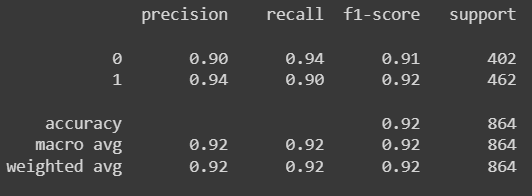

In [ ]:
model.save_pretrained("BERT_sbert_large")

Configuration saved in BERT_sbert_large/config.json
Model weights saved in BERT_sbert_large/pytorch_model.bin


# Model Inference

In [ ]:
def predict_label(text: str) -> int:
  text = tokenizer(text, return_tensors="pt").to("cuda")
  outputs = model(**text)
  pred = torch.argmax(outputs.logits, dim=-1)
  return pred.cpu().numpy()[0]

In [ ]:
test_df["is_fake"] = test_df["title"].apply(predict_label)

In [ ]:
test_df.to_csv('predictions.tsv', sep='\t', index=False)